# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

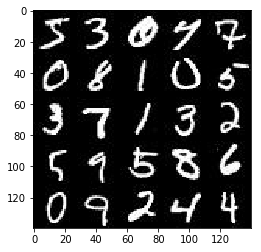

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

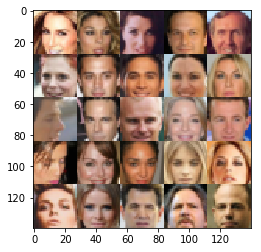

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    in_real = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels), name='input_real')
    in_z  = tf.placeholder(tf.float32, shape=(None,z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, shape=(), name='learning_rate')
    
    return in_real, in_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1, keep_prob=1.0):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input images are 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, kernel_initializer=tf.contrib.layers.xavier_initializer(), strides=2, padding="same")
        x1 = tf.maximum(x1 * alpha, x1)
        if (keep_prob < 1.0):
            x1 = tf.nn.dropout(x1, keep_prob)
        # Should now be 14 x 14 x 128
        
        x2 = tf.layers.conv2d(x1, 256, 5, kernel_initializer=tf.contrib.layers.xavier_initializer(), strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training = True)
        x2 = tf.maximum(x2 * alpha, x2)
        if (keep_prob < 1.0):
            x2 = tf.nn.dropout(x2, keep_prob)
        # Should now be 7 x 7 x 256
        
        x3 = tf.layers.conv2d(x2, 512, 5, kernel_initializer=tf.contrib.layers.xavier_initializer(), strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training = True)
        x3 = tf.maximum(x3 * alpha, x3)
        if (keep_prob < 1.0):
            x3 = tf.nn.dropout(x3, keep_prob)

        # Should now be at 4 x 4 x 512
        
        # Flatten
        logits = tf.layers.dense(tf.reshape(x3, (-1, 4*4*256)), 1)
        outputs = tf.sigmoid(logits)
        
        
        

    return outputs, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1, keep_prob=1.0):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope("generator", reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # CONV 1
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        if (keep_prob < 1.0):
            x1 = tf.nn.dropout(x1, keep_prob)
        
        # This should now be a 7 x 7 x 256 output
        
        # CONV2
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        if (keep_prob < 1.0):
            x2 = tf.nn.dropout(x2, keep_prob)
        
        # This should now be  14 x 14 x 128
        
       
        # CONV3
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3) 
        if (keep_prob < 1.0):
            x3 = tf.nn.dropout(x3, keep_prob)
        
        # This should now be 28 x 28 x 64
        
        # Output layer, 28x28xchannel_dims
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # This should now be 28 x 28 x channel dims
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1, smooth=0.1, d_keep_prob=1.0, g_keep_prob=1.0):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # Generator
    g_model = generator(input_z, out_channel_dim, alpha=alpha, keep_prob=g_keep_prob)
    
    # Discriminator
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha, keep_prob = d_keep_prob)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha, keep_prob = d_keep_prob)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, d_learning_rate=0.001, g_learning_rate=0.001, beta1=0.5):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(d_learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(g_learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, d_learning_rate, g_learning_rate, beta1, d_keep_prob, g_keep_prob, alpha, smooth, get_batches, data_shape, data_image_mode, 
          print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha, smooth, d_keep_prob, g_keep_prob)
    d_opt, g_opt = model_opt(d_loss, g_loss, d_learning_rate, g_learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Re-size the images in the batch to be -1 to 1 (current -0.5 to 0.5)
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
        
        # Print out final loss calculations and images
        train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
        print("Epoch {}/{}...".format(epoch_i + 1, epochs), "Discriminator Loss: {:.4f}...".format(train_loss_d), "Generator Loss: {:.4f}".format(train_loss_g))
        show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
        print("DONE")
        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3937... Generator Loss: 16.9718
Epoch 1/2... Discriminator Loss: 1.2390... Generator Loss: 3.0709
Epoch 1/2... Discriminator Loss: 1.0883... Generator Loss: 1.9129
Epoch 1/2... Discriminator Loss: 2.1180... Generator Loss: 0.5495
Epoch 1/2... Discriminator Loss: 0.6965... Generator Loss: 1.7999
Epoch 1/2... Discriminator Loss: 0.5580... Generator Loss: 2.4387
Epoch 1/2... Discriminator Loss: 1.0571... Generator Loss: 1.6867
Epoch 1/2... Discriminator Loss: 1.0651... Generator Loss: 2.3820
Epoch 1/2... Discriminator Loss: 0.8628... Generator Loss: 1.5472
Epoch 1/2... Discriminator Loss: 0.8199... Generator Loss: 1.3468


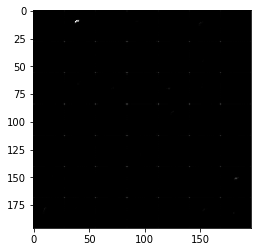

Epoch 1/2... Discriminator Loss: 1.4090... Generator Loss: 0.7508
Epoch 1/2... Discriminator Loss: 1.0653... Generator Loss: 2.4569
Epoch 1/2... Discriminator Loss: 1.4239... Generator Loss: 0.5480
Epoch 1/2... Discriminator Loss: 1.3651... Generator Loss: 0.6660
Epoch 1/2... Discriminator Loss: 1.4834... Generator Loss: 0.5484
Epoch 1/2... Discriminator Loss: 0.9701... Generator Loss: 2.7480
Epoch 1/2... Discriminator Loss: 1.5134... Generator Loss: 0.6465
Epoch 1/2... Discriminator Loss: 1.5124... Generator Loss: 0.6040
Epoch 1/2... Discriminator Loss: 1.4356... Generator Loss: 0.8790
Epoch 1/2... Discriminator Loss: 1.2593... Generator Loss: 0.8512


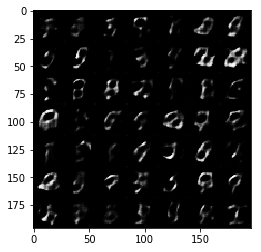

Epoch 1/2... Discriminator Loss: 1.1678... Generator Loss: 0.9015
Epoch 1/2... Discriminator Loss: 1.0106... Generator Loss: 1.0919
Epoch 1/2... Discriminator Loss: 0.9382... Generator Loss: 1.2907
Epoch 1/2... Discriminator Loss: 1.4352... Generator Loss: 0.6304
Epoch 1/2... Discriminator Loss: 1.1193... Generator Loss: 0.9675
Epoch 1/2... Discriminator Loss: 1.0976... Generator Loss: 0.9623
Epoch 1/2... Discriminator Loss: 1.2604... Generator Loss: 0.8881
Epoch 1/2... Discriminator Loss: 1.4708... Generator Loss: 0.4740
Epoch 1/2... Discriminator Loss: 1.3938... Generator Loss: 0.7006
Epoch 1/2... Discriminator Loss: 1.6979... Generator Loss: 0.4165


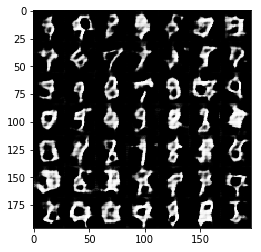

Epoch 1/2... Discriminator Loss: 1.2755... Generator Loss: 0.7629
Epoch 1/2... Discriminator Loss: 1.3367... Generator Loss: 1.6028
Epoch 1/2... Discriminator Loss: 1.2151... Generator Loss: 1.0891
Epoch 1/2... Discriminator Loss: 1.0885... Generator Loss: 0.9428
Epoch 1/2... Discriminator Loss: 1.2695... Generator Loss: 1.2870
Epoch 1/2... Discriminator Loss: 1.2389... Generator Loss: 1.1435
Epoch 1/2... Discriminator Loss: 1.6415... Generator Loss: 0.5272
Epoch 1/2... Discriminator Loss: 1.0938... Generator Loss: 1.2301
Epoch 1/2... Discriminator Loss: 1.1725... Generator Loss: 0.8363
Epoch 1/2... Discriminator Loss: 1.5231... Generator Loss: 0.5382


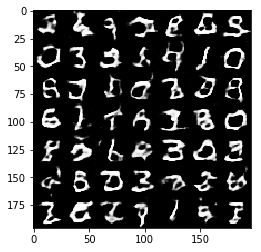

Epoch 1/2... Discriminator Loss: 2.0977... Generator Loss: 0.3135
Epoch 1/2... Discriminator Loss: 0.8673... Generator Loss: 1.2646
Epoch 1/2... Discriminator Loss: 1.1622... Generator Loss: 1.0617
Epoch 1/2... Discriminator Loss: 1.2601... Generator Loss: 1.0450
Epoch 1/2... Discriminator Loss: 0.9152... Generator Loss: 1.3564
Epoch 1/2... Discriminator Loss: 1.1684... Generator Loss: 1.1505
Epoch 1/2... Discriminator Loss: 1.1593... Generator Loss: 1.0678
Epoch 1/2... Discriminator Loss: 1.4216... Generator Loss: 0.6043
Epoch 1/2... Discriminator Loss: 1.1732... Generator Loss: 0.9486
Epoch 1/2... Discriminator Loss: 1.0177... Generator Loss: 0.9606


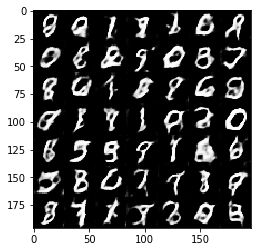

Epoch 1/2... Discriminator Loss: 1.3560... Generator Loss: 2.1909
Epoch 1/2... Discriminator Loss: 0.9013... Generator Loss: 1.1848
Epoch 1/2... Discriminator Loss: 0.9689... Generator Loss: 1.3739
Epoch 1/2... Discriminator Loss: 1.2023... Generator Loss: 0.7742
Epoch 1/2... Discriminator Loss: 1.0880... Generator Loss: 1.9290
Epoch 1/2... Discriminator Loss: 1.1476... Generator Loss: 0.8777
Epoch 1/2... Discriminator Loss: 0.9741... Generator Loss: 1.2206
Epoch 1/2... Discriminator Loss: 0.9795... Generator Loss: 1.1186
Epoch 1/2... Discriminator Loss: 1.2028... Generator Loss: 0.9933
Epoch 1/2... Discriminator Loss: 1.2944... Generator Loss: 0.6727


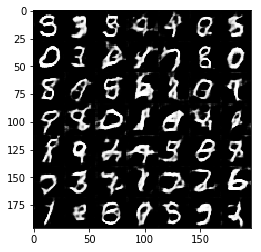

Epoch 1/2... Discriminator Loss: 1.1585... Generator Loss: 1.0140
Epoch 1/2... Discriminator Loss: 1.1470... Generator Loss: 2.5880
Epoch 1/2... Discriminator Loss: 1.0423... Generator Loss: 1.0187
Epoch 1/2... Discriminator Loss: 1.0318... Generator Loss: 1.3963
Epoch 1/2... Discriminator Loss: 1.2372... Generator Loss: 2.0658
Epoch 1/2... Discriminator Loss: 0.9639... Generator Loss: 1.0539
Epoch 1/2... Discriminator Loss: 1.4674... Generator Loss: 1.9850
Epoch 1/2... Discriminator Loss: 0.9889... Generator Loss: 1.5127
Epoch 1/2... Discriminator Loss: 1.0261... Generator Loss: 1.6654
Epoch 1/2... Discriminator Loss: 0.9409... Generator Loss: 1.8741


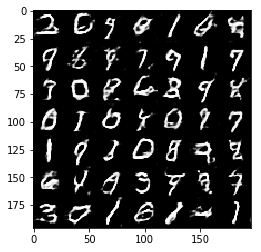

Epoch 1/2... Discriminator Loss: 0.9915... Generator Loss: 1.0551
Epoch 1/2... Discriminator Loss: 1.2566... Generator Loss: 1.4902
Epoch 1/2... Discriminator Loss: 0.9730... Generator Loss: 0.9629
Epoch 1/2... Discriminator Loss: 1.2214... Generator Loss: 2.0880
Epoch 1/2... Discriminator Loss: 1.5420... Generator Loss: 2.9488
Epoch 1/2... Discriminator Loss: 1.0187... Generator Loss: 2.7659
Epoch 1/2... Discriminator Loss: 1.0077... Generator Loss: 1.4113
Epoch 1/2... Discriminator Loss: 1.0307... Generator Loss: 1.5116
Epoch 1/2... Discriminator Loss: 0.9216... Generator Loss: 1.3265
Epoch 1/2... Discriminator Loss: 1.4431... Generator Loss: 0.6082


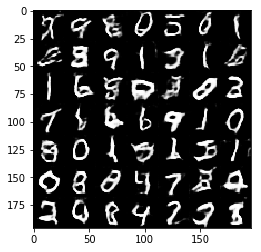

Epoch 1/2... Discriminator Loss: 0.8002... Generator Loss: 1.5511
Epoch 1/2... Discriminator Loss: 0.9484... Generator Loss: 1.7040
Epoch 1/2... Discriminator Loss: 0.9899... Generator Loss: 1.1612
Epoch 1/2... Discriminator Loss: 1.2355... Generator Loss: 2.7124
Epoch 1/2... Discriminator Loss: 0.9164... Generator Loss: 1.3083
Epoch 1/2... Discriminator Loss: 1.1402... Generator Loss: 1.3774
Epoch 1/2... Discriminator Loss: 1.1077... Generator Loss: 1.1245
Epoch 1/2... Discriminator Loss: 1.3306... Generator Loss: 0.6845
Epoch 1/2... Discriminator Loss: 0.8884... Generator Loss: 1.3019
Epoch 1/2... Discriminator Loss: 0.8252... Generator Loss: 1.4952


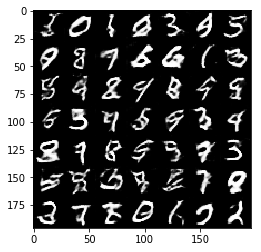

Epoch 1/2... Discriminator Loss: 0.8052... Generator Loss: 1.5011
Epoch 1/2... Discriminator Loss: 1.3526... Generator Loss: 0.6968
Epoch 1/2... Discriminator Loss: 0.9907... Generator Loss: 1.4898
Epoch 1/2... Discriminator Loss: 1.0921... Generator Loss: 0.8777
Epoch 1/2... Discriminator Loss: 0.9196... Generator Loss: 1.8409
Epoch 1/2... Discriminator Loss: 1.2912... Generator Loss: 0.8208
Epoch 1/2... Discriminator Loss: 1.1028... Generator Loss: 1.1228
Epoch 1/2... Discriminator Loss: 0.8371... Generator Loss: 2.0025
Epoch 1/2... Discriminator Loss: 1.0708... Generator Loss: 0.8070
Epoch 1/2... Discriminator Loss: 1.0004... Generator Loss: 1.2847


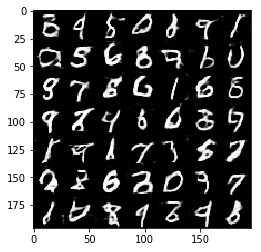

Epoch 1/2... Discriminator Loss: 1.1427... Generator Loss: 0.9173
Epoch 1/2... Discriminator Loss: 1.1700... Generator Loss: 0.7395
Epoch 1/2... Discriminator Loss: 0.9031... Generator Loss: 1.3019
Epoch 1/2... Discriminator Loss: 1.0009... Generator Loss: 1.1507
Epoch 1/2... Discriminator Loss: 0.7681... Generator Loss: 1.7713
Epoch 1/2... Discriminator Loss: 1.0605... Generator Loss: 1.2343
Epoch 1/2... Discriminator Loss: 0.9613... Generator Loss: 1.0789
Epoch 1/2... Discriminator Loss: 0.9521... Generator Loss: 1.8496
Epoch 1/2... Discriminator Loss: 0.7189... Generator Loss: 2.1477
Epoch 1/2... Discriminator Loss: 0.9588... Generator Loss: 1.9771


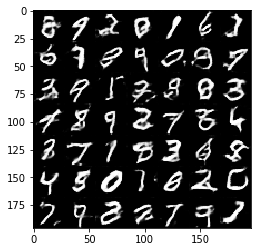

Epoch 1/2... Discriminator Loss: 0.9464... Generator Loss: 1.0884
Epoch 1/2... Discriminator Loss: 0.9308... Generator Loss: 1.4684
Epoch 1/2... Discriminator Loss: 0.8090... Generator Loss: 2.2301
Epoch 1/2... Discriminator Loss: 1.0213... Generator Loss: 1.1659
Epoch 1/2... Discriminator Loss: 0.8418... Generator Loss: 1.9175
Epoch 1/2... Discriminator Loss: 1.3038... Generator Loss: 0.7757
Epoch 1/2... Discriminator Loss: 1.0684... Generator Loss: 1.1673
Epoch 1/2... Discriminator Loss: 1.1833... Generator Loss: 0.8627
Epoch 1/2... Discriminator Loss: 0.9261... Generator Loss: 1.9187
Epoch 1/2... Discriminator Loss: 0.9577... Generator Loss: 1.3331


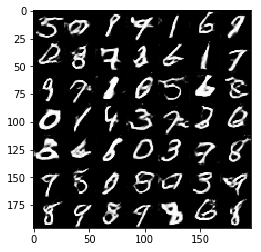

Epoch 1/2... Discriminator Loss: 0.8923... Generator Loss: 1.3390
Epoch 1/2... Discriminator Loss: 1.0401... Generator Loss: 1.1070
Epoch 1/2... Discriminator Loss: 0.9844... Generator Loss: 1.4242
Epoch 1/2... Discriminator Loss: 0.9159... Generator Loss: 1.2227
Epoch 1/2... Discriminator Loss: 0.9241... Generator Loss: 1.3927
Epoch 1/2... Discriminator Loss: 0.9057... Generator Loss: 1.2233
Epoch 1/2... Discriminator Loss: 1.0708... Generator Loss: 0.9773
Epoch 1/2... Discriminator Loss: 0.8447... Generator Loss: 1.6550
Epoch 1/2... Discriminator Loss: 1.1918... Generator Loss: 1.0178
Epoch 1/2... Discriminator Loss: 0.9751... Generator Loss: 1.4268


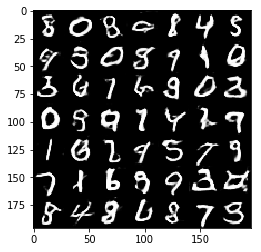

Epoch 1/2... Discriminator Loss: 0.9771... Generator Loss: 2.6184
Epoch 1/2... Discriminator Loss: 0.8928... Generator Loss: 1.3208
Epoch 1/2... Discriminator Loss: 0.8564... Generator Loss: 1.2353
Epoch 1/2... Discriminator Loss: 0.8898... Generator Loss: 1.3144
Epoch 1/2... Discriminator Loss: 1.0174... Generator Loss: 1.1583
Epoch 1/2... Discriminator Loss: 1.2583... Generator Loss: 0.6988
Epoch 1/2... Discriminator Loss: 1.0704... Generator Loss: 2.1702
Epoch 1/2... Discriminator Loss: 0.8433... Generator Loss: 1.4253
Epoch 1/2... Discriminator Loss: 0.5836... Generator Loss: 2.1141
Epoch 1/2... Discriminator Loss: 0.9651... Generator Loss: 1.3849


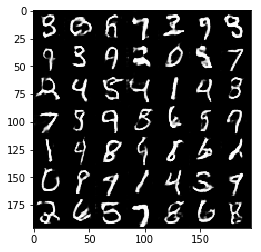

Epoch 1/2... Discriminator Loss: 0.8614... Generator Loss: 1.4910
Epoch 1/2... Discriminator Loss: 0.9824... Generator Loss: 1.2054
Epoch 1/2... Discriminator Loss: 1.1230... Generator Loss: 0.8059
Epoch 1/2... Discriminator Loss: 0.9085... Generator Loss: 1.1137
Epoch 1/2... Discriminator Loss: 1.0448... Generator Loss: 1.2120
Epoch 1/2... Discriminator Loss: 0.9275... Generator Loss: 1.4306
Epoch 1/2... Discriminator Loss: 1.0720... Generator Loss: 0.8181
Epoch 1/2... Discriminator Loss: 0.8373... Generator Loss: 1.3575
Epoch 1/2... Discriminator Loss: 1.3964... Generator Loss: 2.2936
Epoch 1/2... Discriminator Loss: 0.7869... Generator Loss: 1.4109


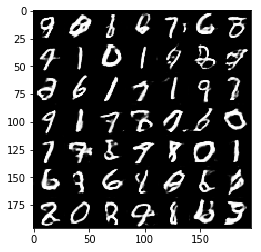

Epoch 1/2... Discriminator Loss: 1.4345... Generator Loss: 0.6323
Epoch 1/2... Discriminator Loss: 0.7518... Generator Loss: 1.8414
Epoch 1/2... Discriminator Loss: 0.8205... Generator Loss: 1.4652
Epoch 1/2... Discriminator Loss: 0.7620... Generator Loss: 2.0232
Epoch 1/2... Discriminator Loss: 0.7754... Generator Loss: 1.4074
Epoch 1/2... Discriminator Loss: 0.9885... Generator Loss: 1.3209
Epoch 1/2... Discriminator Loss: 0.7171... Generator Loss: 2.1084
Epoch 1/2... Discriminator Loss: 0.8834... Generator Loss: 1.5613
Epoch 1/2... Discriminator Loss: 0.7963... Generator Loss: 1.7095
Epoch 1/2... Discriminator Loss: 1.1396... Generator Loss: 0.9768


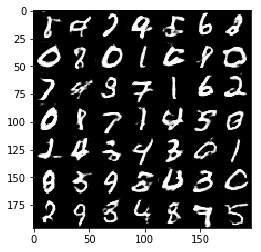

Epoch 1/2... Discriminator Loss: 1.5843... Generator Loss: 0.4648
Epoch 1/2... Discriminator Loss: 1.0717... Generator Loss: 0.9923
Epoch 1/2... Discriminator Loss: 0.8395... Generator Loss: 1.7563
Epoch 1/2... Discriminator Loss: 0.8222... Generator Loss: 1.2569
Epoch 1/2... Discriminator Loss: 0.6406... Generator Loss: 1.8494
Epoch 1/2... Discriminator Loss: 0.9577... Generator Loss: 1.6970
Epoch 1/2... Discriminator Loss: 0.9741... Generator Loss: 1.0413
Epoch 1/2... Discriminator Loss: 0.5650... Generator Loss: 2.3554
Epoch 1/2... Discriminator Loss: 1.0140... Generator Loss: 1.2010
Epoch 1/2... Discriminator Loss: 0.9401... Generator Loss: 1.3012


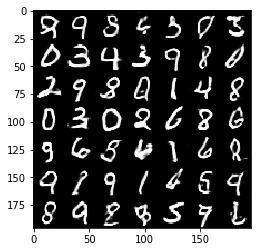

Epoch 1/2... Discriminator Loss: 0.6436... Generator Loss: 2.0864
Epoch 1/2... Discriminator Loss: 1.0393... Generator Loss: 1.0977
Epoch 1/2... Discriminator Loss: 1.0913... Generator Loss: 1.0432
Epoch 1/2... Discriminator Loss: 0.9978... Generator Loss: 1.0113
Epoch 1/2... Discriminator Loss: 0.7617... Generator Loss: 1.5664
Epoch 1/2... Discriminator Loss: 0.7467... Generator Loss: 1.4611
Epoch 1/2... Discriminator Loss: 0.9671... Generator Loss: 1.0608
Epoch 1/2... Discriminator Loss: 0.9912... Generator Loss: 2.1550
Epoch 1/2... Discriminator Loss: 0.8958... Generator Loss: 1.2504
Epoch 1/2... Discriminator Loss: 0.6784... Generator Loss: 1.8427


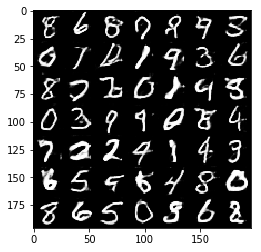

Epoch 1/2... Discriminator Loss: 0.9612... Generator Loss: 1.9396
Epoch 1/2... Discriminator Loss: 0.7174... Generator Loss: 2.1111
Epoch 1/2... Discriminator Loss: 1.4401... Generator Loss: 2.4953
Epoch 1/2... Discriminator Loss: 0.9434... Generator Loss: 1.5124
Epoch 1/2... Discriminator Loss: 0.8277... Generator Loss: 1.8063
Epoch 1/2... Discriminator Loss: 1.3865... Generator Loss: 0.6519
Epoch 1/2... Discriminator Loss: 0.7231... Generator Loss: 2.0589
Epoch 2/2... Discriminator Loss: 0.8450... Generator Loss: 2.3364
Epoch 2/2... Discriminator Loss: 0.6497... Generator Loss: 1.6795
Epoch 2/2... Discriminator Loss: 0.8914... Generator Loss: 1.8966


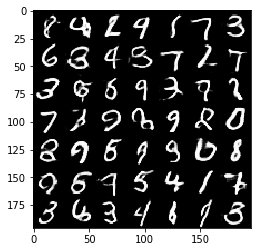

Epoch 2/2... Discriminator Loss: 1.0624... Generator Loss: 2.3250
Epoch 2/2... Discriminator Loss: 0.8091... Generator Loss: 1.1419
Epoch 2/2... Discriminator Loss: 0.8300... Generator Loss: 1.4163
Epoch 2/2... Discriminator Loss: 0.9592... Generator Loss: 0.9120
Epoch 2/2... Discriminator Loss: 0.7738... Generator Loss: 1.3579
Epoch 2/2... Discriminator Loss: 1.1600... Generator Loss: 0.9537
Epoch 2/2... Discriminator Loss: 1.4344... Generator Loss: 0.7563
Epoch 2/2... Discriminator Loss: 1.0948... Generator Loss: 1.0314
Epoch 2/2... Discriminator Loss: 0.6835... Generator Loss: 1.5957
Epoch 2/2... Discriminator Loss: 0.9110... Generator Loss: 1.4823


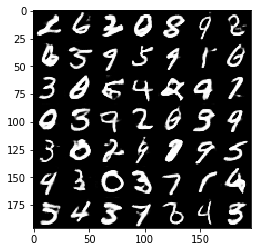

Epoch 2/2... Discriminator Loss: 0.9994... Generator Loss: 1.7894
Epoch 2/2... Discriminator Loss: 0.7409... Generator Loss: 2.3612
Epoch 2/2... Discriminator Loss: 0.8898... Generator Loss: 1.3013
Epoch 2/2... Discriminator Loss: 0.7254... Generator Loss: 2.3266
Epoch 2/2... Discriminator Loss: 0.9732... Generator Loss: 1.4296
Epoch 2/2... Discriminator Loss: 0.6245... Generator Loss: 2.0744
Epoch 2/2... Discriminator Loss: 0.7288... Generator Loss: 2.1439
Epoch 2/2... Discriminator Loss: 0.8595... Generator Loss: 1.2319
Epoch 2/2... Discriminator Loss: 1.1583... Generator Loss: 0.7574
Epoch 2/2... Discriminator Loss: 0.8934... Generator Loss: 1.3122


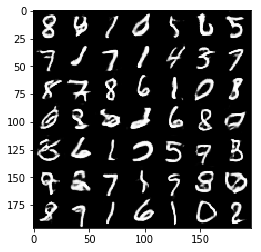

Epoch 2/2... Discriminator Loss: 0.9213... Generator Loss: 1.3189
Epoch 2/2... Discriminator Loss: 0.8307... Generator Loss: 1.6715
Epoch 2/2... Discriminator Loss: 0.7676... Generator Loss: 1.3396
Epoch 2/2... Discriminator Loss: 1.1307... Generator Loss: 2.2108
Epoch 2/2... Discriminator Loss: 1.2273... Generator Loss: 0.8962
Epoch 2/2... Discriminator Loss: 0.7294... Generator Loss: 1.4246
Epoch 2/2... Discriminator Loss: 0.8290... Generator Loss: 1.5128
Epoch 2/2... Discriminator Loss: 1.5990... Generator Loss: 3.7256
Epoch 2/2... Discriminator Loss: 0.7262... Generator Loss: 1.3904
Epoch 2/2... Discriminator Loss: 0.8741... Generator Loss: 2.1657


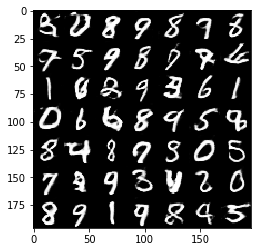

Epoch 2/2... Discriminator Loss: 0.9883... Generator Loss: 1.3835
Epoch 2/2... Discriminator Loss: 0.6697... Generator Loss: 2.1603
Epoch 2/2... Discriminator Loss: 0.8451... Generator Loss: 1.5042
Epoch 2/2... Discriminator Loss: 0.6445... Generator Loss: 1.7962
Epoch 2/2... Discriminator Loss: 0.8240... Generator Loss: 1.3790
Epoch 2/2... Discriminator Loss: 0.7523... Generator Loss: 1.7640
Epoch 2/2... Discriminator Loss: 0.8447... Generator Loss: 2.2920
Epoch 2/2... Discriminator Loss: 0.5624... Generator Loss: 2.3482
Epoch 2/2... Discriminator Loss: 0.8362... Generator Loss: 1.5475
Epoch 2/2... Discriminator Loss: 0.8313... Generator Loss: 2.4457


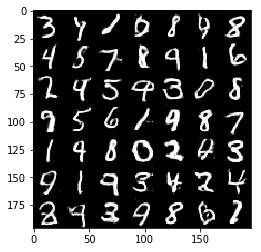

Epoch 2/2... Discriminator Loss: 0.7996... Generator Loss: 2.0135
Epoch 2/2... Discriminator Loss: 0.7861... Generator Loss: 1.9725
Epoch 2/2... Discriminator Loss: 0.6367... Generator Loss: 2.5502
Epoch 2/2... Discriminator Loss: 0.7066... Generator Loss: 2.0826
Epoch 2/2... Discriminator Loss: 0.8545... Generator Loss: 2.9967
Epoch 2/2... Discriminator Loss: 0.9026... Generator Loss: 2.5421
Epoch 2/2... Discriminator Loss: 1.0806... Generator Loss: 2.0725
Epoch 2/2... Discriminator Loss: 1.1427... Generator Loss: 0.8321
Epoch 2/2... Discriminator Loss: 0.9531... Generator Loss: 1.2302
Epoch 2/2... Discriminator Loss: 1.0093... Generator Loss: 0.9124


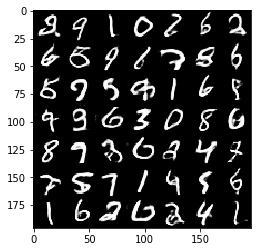

Epoch 2/2... Discriminator Loss: 0.8870... Generator Loss: 1.7516
Epoch 2/2... Discriminator Loss: 0.7504... Generator Loss: 1.8973
Epoch 2/2... Discriminator Loss: 0.6778... Generator Loss: 2.1123
Epoch 2/2... Discriminator Loss: 0.8708... Generator Loss: 1.3770
Epoch 2/2... Discriminator Loss: 0.7962... Generator Loss: 1.3988
Epoch 2/2... Discriminator Loss: 0.7312... Generator Loss: 2.2080
Epoch 2/2... Discriminator Loss: 0.9036... Generator Loss: 1.5688
Epoch 2/2... Discriminator Loss: 0.5144... Generator Loss: 3.1077
Epoch 2/2... Discriminator Loss: 0.5964... Generator Loss: 1.6296
Epoch 2/2... Discriminator Loss: 0.9472... Generator Loss: 1.0883


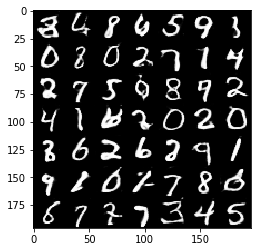

Epoch 2/2... Discriminator Loss: 0.8936... Generator Loss: 1.7658
Epoch 2/2... Discriminator Loss: 0.7051... Generator Loss: 1.5112
Epoch 2/2... Discriminator Loss: 1.2064... Generator Loss: 2.7964
Epoch 2/2... Discriminator Loss: 0.8728... Generator Loss: 1.3021
Epoch 2/2... Discriminator Loss: 0.9842... Generator Loss: 0.9803
Epoch 2/2... Discriminator Loss: 0.7529... Generator Loss: 2.2615
Epoch 2/2... Discriminator Loss: 0.6303... Generator Loss: 2.4175
Epoch 2/2... Discriminator Loss: 1.5836... Generator Loss: 3.5698
Epoch 2/2... Discriminator Loss: 0.9456... Generator Loss: 1.6698
Epoch 2/2... Discriminator Loss: 1.0494... Generator Loss: 2.4769


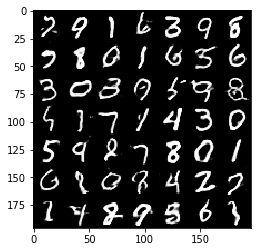

Epoch 2/2... Discriminator Loss: 0.8058... Generator Loss: 1.5451
Epoch 2/2... Discriminator Loss: 0.7375... Generator Loss: 1.6261
Epoch 2/2... Discriminator Loss: 0.8262... Generator Loss: 2.2033
Epoch 2/2... Discriminator Loss: 1.1912... Generator Loss: 0.8542
Epoch 2/2... Discriminator Loss: 0.7890... Generator Loss: 2.1001
Epoch 2/2... Discriminator Loss: 0.9537... Generator Loss: 1.3622
Epoch 2/2... Discriminator Loss: 0.6877... Generator Loss: 2.3353
Epoch 2/2... Discriminator Loss: 0.6967... Generator Loss: 2.9955
Epoch 2/2... Discriminator Loss: 0.6869... Generator Loss: 1.8510
Epoch 2/2... Discriminator Loss: 0.9715... Generator Loss: 1.1416


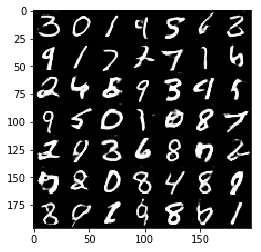

Epoch 2/2... Discriminator Loss: 0.7335... Generator Loss: 1.5218
Epoch 2/2... Discriminator Loss: 0.8565... Generator Loss: 1.0381
Epoch 2/2... Discriminator Loss: 1.5096... Generator Loss: 0.6781
Epoch 2/2... Discriminator Loss: 0.7624... Generator Loss: 1.5167
Epoch 2/2... Discriminator Loss: 0.6306... Generator Loss: 2.1477
Epoch 2/2... Discriminator Loss: 1.3958... Generator Loss: 0.7279
Epoch 2/2... Discriminator Loss: 0.6756... Generator Loss: 1.7221
Epoch 2/2... Discriminator Loss: 0.6216... Generator Loss: 2.7670
Epoch 2/2... Discriminator Loss: 1.0536... Generator Loss: 1.2651
Epoch 2/2... Discriminator Loss: 0.9165... Generator Loss: 1.0194


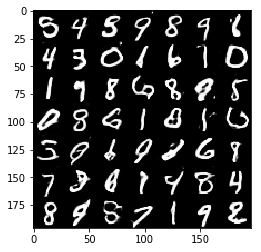

Epoch 2/2... Discriminator Loss: 0.9448... Generator Loss: 2.4977
Epoch 2/2... Discriminator Loss: 0.6158... Generator Loss: 2.0294
Epoch 2/2... Discriminator Loss: 0.6392... Generator Loss: 2.6615
Epoch 2/2... Discriminator Loss: 0.8846... Generator Loss: 2.3576
Epoch 2/2... Discriminator Loss: 0.8129... Generator Loss: 0.9503
Epoch 2/2... Discriminator Loss: 0.8732... Generator Loss: 2.6238
Epoch 2/2... Discriminator Loss: 0.8019... Generator Loss: 1.4539
Epoch 2/2... Discriminator Loss: 0.6871... Generator Loss: 3.2954
Epoch 2/2... Discriminator Loss: 0.6255... Generator Loss: 2.5874
Epoch 2/2... Discriminator Loss: 1.1423... Generator Loss: 2.9474


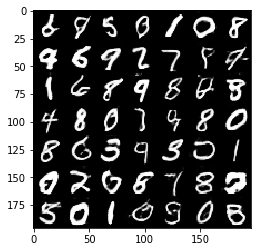

Epoch 2/2... Discriminator Loss: 0.7029... Generator Loss: 3.5317
Epoch 2/2... Discriminator Loss: 0.8185... Generator Loss: 1.5242
Epoch 2/2... Discriminator Loss: 0.6083... Generator Loss: 2.2594
Epoch 2/2... Discriminator Loss: 0.8280... Generator Loss: 1.4555
Epoch 2/2... Discriminator Loss: 0.7918... Generator Loss: 1.5835
Epoch 2/2... Discriminator Loss: 1.0138... Generator Loss: 3.0777
Epoch 2/2... Discriminator Loss: 0.7460... Generator Loss: 2.0572
Epoch 2/2... Discriminator Loss: 0.5921... Generator Loss: 2.2803
Epoch 2/2... Discriminator Loss: 0.7054... Generator Loss: 2.3815
Epoch 2/2... Discriminator Loss: 0.7227... Generator Loss: 1.7162


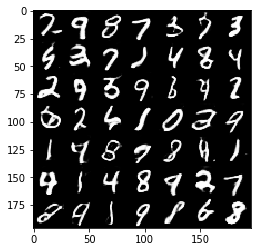

Epoch 2/2... Discriminator Loss: 0.9076... Generator Loss: 1.7757
Epoch 2/2... Discriminator Loss: 0.6784... Generator Loss: 2.0409
Epoch 2/2... Discriminator Loss: 1.0022... Generator Loss: 3.9081
Epoch 2/2... Discriminator Loss: 0.8685... Generator Loss: 1.0458
Epoch 2/2... Discriminator Loss: 0.6132... Generator Loss: 2.0420
Epoch 2/2... Discriminator Loss: 0.6336... Generator Loss: 1.6075
Epoch 2/2... Discriminator Loss: 0.5575... Generator Loss: 2.4026
Epoch 2/2... Discriminator Loss: 0.6295... Generator Loss: 1.8985
Epoch 2/2... Discriminator Loss: 0.9934... Generator Loss: 1.4502
Epoch 2/2... Discriminator Loss: 0.6315... Generator Loss: 2.7721


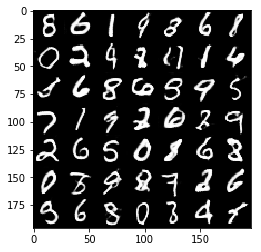

Epoch 2/2... Discriminator Loss: 0.7241... Generator Loss: 2.3225
Epoch 2/2... Discriminator Loss: 0.7825... Generator Loss: 3.3888
Epoch 2/2... Discriminator Loss: 0.9139... Generator Loss: 1.3283
Epoch 2/2... Discriminator Loss: 0.7146... Generator Loss: 1.9066
Epoch 2/2... Discriminator Loss: 0.9562... Generator Loss: 1.4360
Epoch 2/2... Discriminator Loss: 0.5787... Generator Loss: 2.4979
Epoch 2/2... Discriminator Loss: 0.6215... Generator Loss: 2.2176
Epoch 2/2... Discriminator Loss: 0.7207... Generator Loss: 1.8535
Epoch 2/2... Discriminator Loss: 0.6618... Generator Loss: 2.7811
Epoch 2/2... Discriminator Loss: 0.7210... Generator Loss: 1.7513


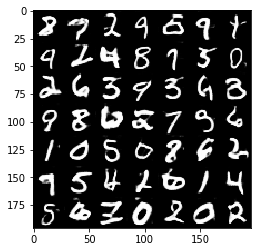

Epoch 2/2... Discriminator Loss: 0.7899... Generator Loss: 1.4577
Epoch 2/2... Discriminator Loss: 0.7841... Generator Loss: 2.4954
Epoch 2/2... Discriminator Loss: 0.6531... Generator Loss: 2.2499
Epoch 2/2... Discriminator Loss: 0.6477... Generator Loss: 3.1634
Epoch 2/2... Discriminator Loss: 0.5858... Generator Loss: 2.1457
Epoch 2/2... Discriminator Loss: 0.6078... Generator Loss: 2.3426
Epoch 2/2... Discriminator Loss: 1.0111... Generator Loss: 1.4126
Epoch 2/2... Discriminator Loss: 0.8199... Generator Loss: 1.3521
Epoch 2/2... Discriminator Loss: 0.8717... Generator Loss: 1.4989
Epoch 2/2... Discriminator Loss: 0.5547... Generator Loss: 2.7845


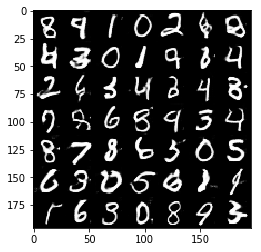

Epoch 2/2... Discriminator Loss: 0.6225... Generator Loss: 2.2802
Epoch 2/2... Discriminator Loss: 0.5353... Generator Loss: 2.3100
Epoch 2/2... Discriminator Loss: 0.8016... Generator Loss: 2.6507
Epoch 2/2... Discriminator Loss: 0.6003... Generator Loss: 2.8491
Epoch 2/2... Discriminator Loss: 0.7874... Generator Loss: 3.3138
Epoch 2/2... Discriminator Loss: 0.5244... Generator Loss: 2.9409
Epoch 2/2... Discriminator Loss: 0.9926... Generator Loss: 1.1593
Epoch 2/2... Discriminator Loss: 0.6827... Generator Loss: 2.1968
Epoch 2/2... Discriminator Loss: 0.7878... Generator Loss: 1.7762
Epoch 2/2... Discriminator Loss: 0.6535... Generator Loss: 1.5799


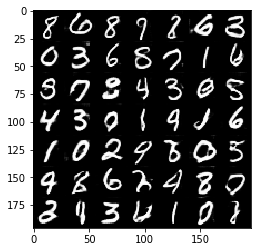

Epoch 2/2... Discriminator Loss: 0.8080... Generator Loss: 2.9967
Epoch 2/2... Discriminator Loss: 0.8946... Generator Loss: 3.0784
Epoch 2/2... Discriminator Loss: 0.6632... Generator Loss: 2.2257
Epoch 2/2... Discriminator Loss: 0.5542... Generator Loss: 2.5724
Epoch 2/2... Discriminator Loss: 0.6746... Generator Loss: 1.7528
Epoch 2/2... Discriminator Loss: 1.2561... Generator Loss: 0.8234
Epoch 2/2... Discriminator Loss: 0.5304... Generator Loss: 2.4925
Epoch 2/2... Discriminator Loss: 0.5272... Generator Loss: 2.6881
Epoch 2/2... Discriminator Loss: 1.3000... Generator Loss: 4.0696
Epoch 2/2... Discriminator Loss: 0.6653... Generator Loss: 1.6719


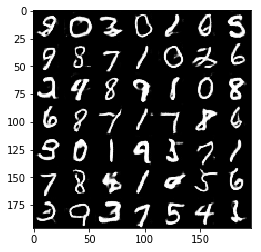

Epoch 2/2... Discriminator Loss: 0.8849... Generator Loss: 1.7004
Epoch 2/2... Discriminator Loss: 0.6226... Generator Loss: 2.3347
Epoch 2/2... Discriminator Loss: 0.5526... Generator Loss: 2.1070
Epoch 2/2... Discriminator Loss: 0.7204... Generator Loss: 2.7105
Epoch 2/2... Discriminator Loss: 0.7217... Generator Loss: 2.0151
Epoch 2/2... Discriminator Loss: 1.1131... Generator Loss: 3.1993
Epoch 2/2... Discriminator Loss: 0.7451... Generator Loss: 1.8498
Epoch 2/2... Discriminator Loss: 0.6394... Generator Loss: 1.6505
Epoch 2/2... Discriminator Loss: 1.3708... Generator Loss: 0.7176
Epoch 2/2... Discriminator Loss: 0.8300... Generator Loss: 1.6025


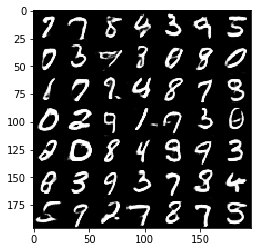

Epoch 2/2... Discriminator Loss: 0.6949... Generator Loss: 1.9069
Epoch 2/2... Discriminator Loss: 0.8224... Generator Loss: 2.0431
Epoch 2/2... Discriminator Loss: 0.5617... Generator Loss: 2.0132
Epoch 2/2... Discriminator Loss: 0.7251... Generator Loss: 2.7185
Epoch 2/2... Discriminator Loss: 0.6734... Generator Loss: 2.3572
Epoch 2/2... Discriminator Loss: 0.6427... Generator Loss: 2.1397
Epoch 2/2... Discriminator Loss: 0.7492... Generator Loss: 2.4496
Epoch 2/2... Discriminator Loss: 0.6886... Generator Loss: 1.4016
Epoch 2/2... Discriminator Loss: 0.6213... Generator Loss: 2.2105
Epoch 2/2... Discriminator Loss: 1.0007... Generator Loss: 2.3181


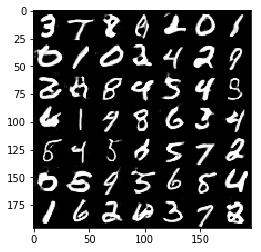

Epoch 2/2... Discriminator Loss: 0.7309... Generator Loss: 3.5760
Epoch 2/2... Discriminator Loss: 0.9738... Generator Loss: 3.5110
Epoch 2/2... Discriminator Loss: 0.5931... Generator Loss: 2.1008
Epoch 2/2... Discriminator Loss: 0.5790... Generator Loss: 2.9705
Epoch 2/2... Discriminator Loss: 0.5653... Generator Loss: 3.0404
Epoch 2/2... Discriminator Loss: 0.6701... Generator Loss: 3.3975


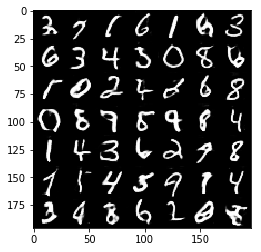

DONE


In [13]:
batch_size = 32
z_dim = 100
beta1 = 0.5
alpha = 0.1

d_learning_rate = 0.001
g_learning_rate = 0.001
d_keep_prob = 0.8
g_keep_prob = 0.5
smooth = 0.1



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, d_learning_rate, g_learning_rate, beta1, d_keep_prob, g_keep_prob, alpha, smooth, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8184... Generator Loss: 5.2635
Epoch 1/1... Discriminator Loss: 0.5167... Generator Loss: 3.5560
Epoch 1/1... Discriminator Loss: 0.8507... Generator Loss: 3.1435
Epoch 1/1... Discriminator Loss: 0.7249... Generator Loss: 1.5857
Epoch 1/1... Discriminator Loss: 0.6620... Generator Loss: 2.0209
Epoch 1/1... Discriminator Loss: 0.4271... Generator Loss: 3.0610
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 0.8126... Generator Loss: 1.8707
Epoch 1/1... Discriminator Loss: 0.6641... Generator Loss: 1.7620
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.6113


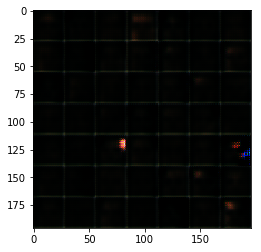

Epoch 1/1... Discriminator Loss: 0.8340... Generator Loss: 1.6590
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 2.2044
Epoch 1/1... Discriminator Loss: 0.8224... Generator Loss: 1.3971
Epoch 1/1... Discriminator Loss: 0.8843... Generator Loss: 1.9885
Epoch 1/1... Discriminator Loss: 1.6270... Generator Loss: 0.4350
Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 1.4280
Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 1.2877
Epoch 1/1... Discriminator Loss: 1.6273... Generator Loss: 0.4825
Epoch 1/1... Discriminator Loss: 4.9200... Generator Loss: 4.8941


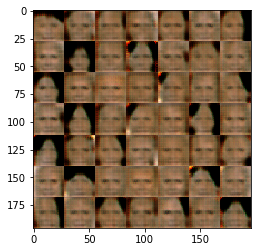

Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 1.0035
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 1.1911
Epoch 1/1... Discriminator Loss: 0.9475... Generator Loss: 1.4624
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 1.6953
Epoch 1/1... Discriminator Loss: 1.9509... Generator Loss: 2.6599
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 1.3130
Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 1.6283


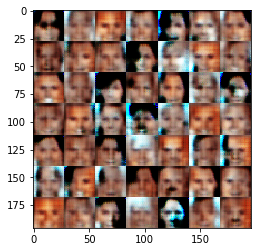

Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 0.8523... Generator Loss: 1.2979
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 1.1279
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 1.9081
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 0.9522
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 1.0743
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.7653


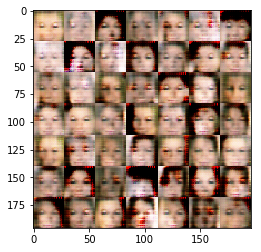

Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 2.2753
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 1.0385
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 1.5990
Epoch 1/1... Discriminator Loss: 0.7802... Generator Loss: 1.3005
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 0.8591... Generator Loss: 1.9665
Epoch 1/1... Discriminator Loss: 1.8751... Generator Loss: 0.3414
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 1.1329
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 1.0766


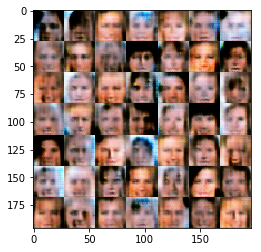

Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 1.1502
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.9753
Epoch 1/1... Discriminator Loss: 0.8895... Generator Loss: 1.2054
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 1.2975
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.7345... Generator Loss: 1.9091
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 1.3356


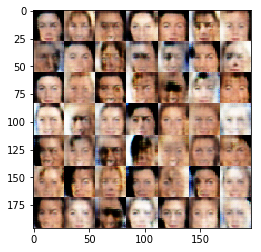

Epoch 1/1... Discriminator Loss: 0.9683... Generator Loss: 1.4490
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 1.2100
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 1.0967
Epoch 1/1... Discriminator Loss: 1.9411... Generator Loss: 0.3390
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 1.1748
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 1.0765
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.6007... Generator Loss: 0.4139


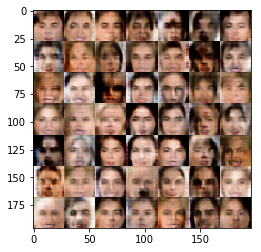

Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 1.2496
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 1.2875
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 1.4280
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 1.2612
Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 1.0647
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.4698
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 1.9378
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 1.3844


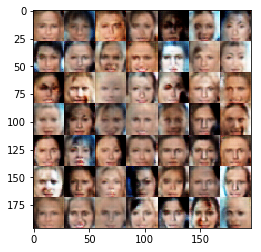

Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.5356
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.9101
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 1.6330
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 0.9877... Generator Loss: 0.9587
Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 1.9148
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.8745


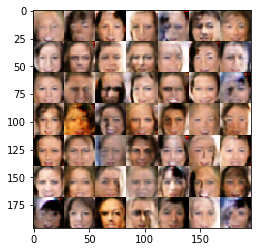

Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 1.2579
Epoch 1/1... Discriminator Loss: 0.9868... Generator Loss: 1.1632
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 1.2840
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 0.9958
Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 0.9827
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 1.2622
Epoch 1/1... Discriminator Loss: 0.9813... Generator Loss: 1.1657
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 1.3328


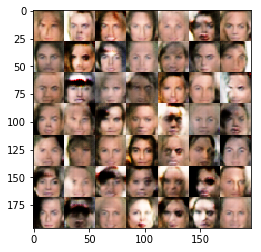

Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 1.3924
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.5509
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 1.0457
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 1.1456
Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 1.2435
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 1.1185
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 0.5381... Generator Loss: 2.3288
Epoch 1/1... Discriminator Loss: 0.6732... Generator Loss: 1.8650
Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 0.9766


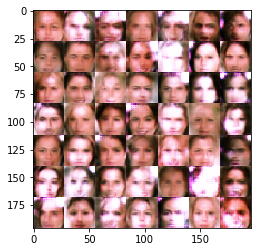

Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 1.1653
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 1.2125
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 1.3645
Epoch 1/1... Discriminator Loss: 1.0731... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 0.9580... Generator Loss: 0.9826
Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 2.5100... Generator Loss: 0.1713
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 1.0208
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 0.9795
Epoch 1/1... Discriminator Loss: 1.2961... Generator Loss: 0.6608


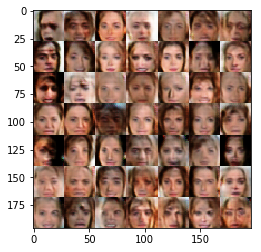

Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 1.2436
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 1.5766
Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 1.1586
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 1.4345
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 1.3321
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 1.3345
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.5927


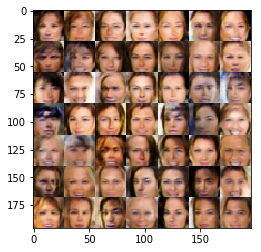

Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 1.0370
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.5450
Epoch 1/1... Discriminator Loss: 1.1208... Generator Loss: 1.1753
Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 1.1017
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 1.0091
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 1.1684
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 1.5026
Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 1.0356
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 0.7380


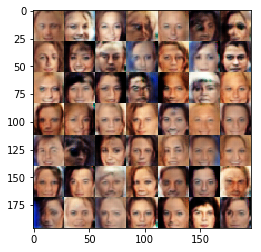

Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 1.5500
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 1.3155
Epoch 1/1... Discriminator Loss: 0.9075... Generator Loss: 1.2710
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 1.0499
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.6573


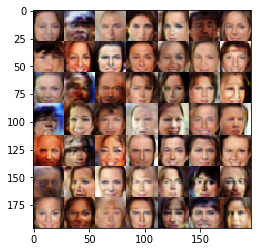

Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 1.2566
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 1.4030
Epoch 1/1... Discriminator Loss: 1.5665... Generator Loss: 0.4657
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 1.4201
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 1.1677
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 1.0260


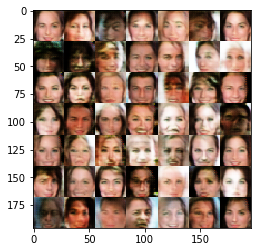

Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 0.8973
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 1.0030
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 1.7640
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 1.2940
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 1.6084
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 1.3053
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 1.0347


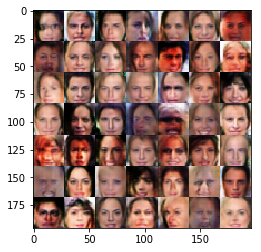

Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 1.6537
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 1.2699
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 1.6278
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 1.1636
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.6050
Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 1.3726
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 1.2191
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.6433


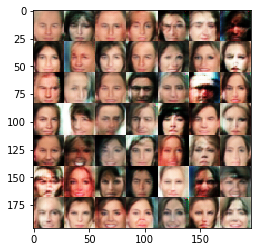

Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 1.2072
Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 1.1349
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 1.0395
Epoch 1/1... Discriminator Loss: 1.6047... Generator Loss: 0.4578
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.7596... Generator Loss: 2.2268
Epoch 1/1... Discriminator Loss: 1.5522... Generator Loss: 0.3942
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 0.8473


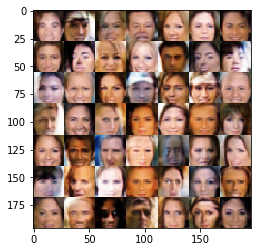

Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 1.5917
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 1.1634
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 1.0058
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 1.6352
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 1.1304
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 1.6953
Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 1.0400


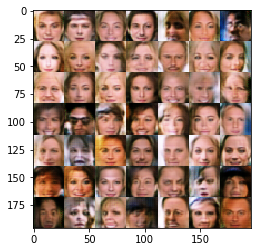

Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 1.6158
Epoch 1/1... Discriminator Loss: 1.0731... Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 1.1817
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 1.5171
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.9671
Epoch 1/1... Discriminator Loss: 1.0860... Generator Loss: 1.3718
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.9908


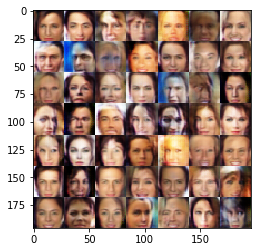

Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 1.1422
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 1.0912
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 1.3565
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 1.3581
Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 1.1632
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 1.2137
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 0.9780
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 1.1666


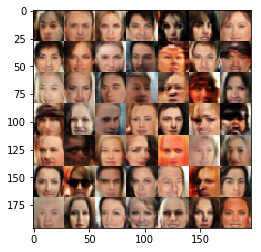

Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 1.1406
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 1.4346
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 1.1245
Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 1.3345
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 1.3313
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 1.3102
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 1.3562


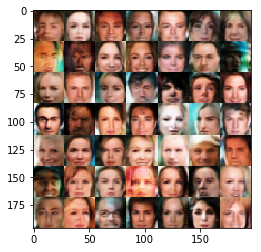

Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 1.2013
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 1.5011
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 1.1656
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.9561
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 1.2157
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 1.0957
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 1.1697
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 1.4266


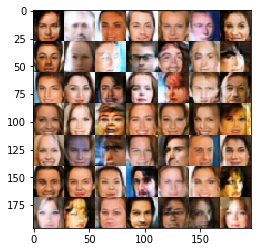

Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 2.1102
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 0.9889
Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 1.4443
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 1.5160
Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 1.2036
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 1.4011
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 1.0309
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.3625
Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 1.2868


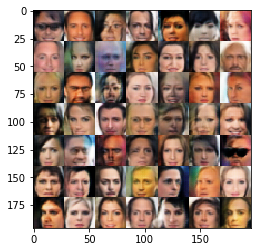

Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 1.0851
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 1.2101
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 1.2767
Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 1.1513
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 1.4301
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 1.3826
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 0.7662


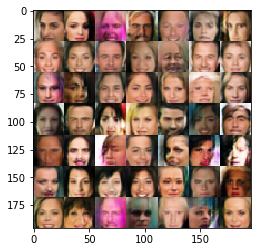

Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 1.1215
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 1.5853
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 1.4387
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 1.1991
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 1.6225
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 1.0389
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 0.9959
Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 1.0676


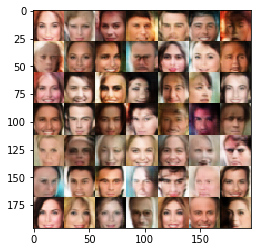

Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 1.4920
Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 1.1493
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 1.7225
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 1.1846
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 1.5115
Epoch 1/1... Discriminator Loss: 1.0085... Generator Loss: 1.0761
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 2.0789


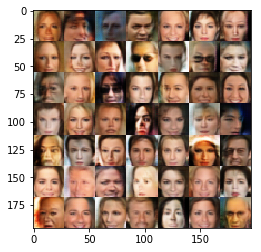

Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 1.0126
Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 1.1626
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 0.9362
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 1.3431
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 1.2204
Epoch 1/1... Discriminator Loss: 1.0132... Generator Loss: 1.4735
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 0.8944
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 1.2106
Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 1.5346


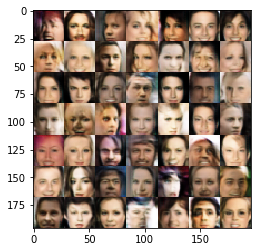

Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 1.9042
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 1.3606
Epoch 1/1... Discriminator Loss: 1.0806... Generator Loss: 1.1009
Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 1.1993
Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 1.1958
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 1.8436
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 1.4064
Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 0.9793


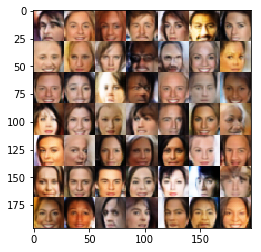

Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 1.3233
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 0.9790... Generator Loss: 1.3332
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 1.6474
Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 1.6105
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 1.4405
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 1.2215
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 0.8659


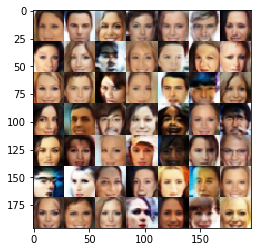

Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 1.0330
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 1.3037
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 2.0380
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 1.0514
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 1.2531


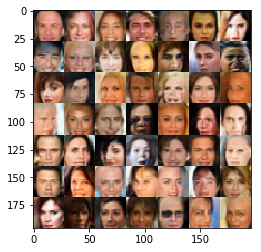

DONE


In [14]:
batch_size = 64
z_dim = 100
beta1 = 0.5
alpha = 0.1

d_learning_rate = 0.001
g_learning_rate = 0.001
d_keep_prob = 0.8
g_keep_prob = 0.5
smooth = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, d_learning_rate, g_learning_rate, beta1, d_keep_prob, g_keep_prob, alpha, smooth, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.